This notebook is to try to implement the Quadratic Energy algorithm that is mentioned in this paper: https://www.ifaamas.org/Proceedings/aamas2019/pdfs/p1722.pdf. For the other solving algorithms of the acceptibility semantics, since they follows a similar pipeline, it's easy to development them by starting from what we will have below. 

To validate the algorithm correctness, we use the stock example mentioned in this notebook: https://github.com/nicopotyka/Uncertainpy/blob/master/examples/gradual/gradual_argumentation_examples.ipynb.

In [1]:
import numpy as np

# A simple example: BAG containing three arguments {a, b, c} 
# links: attack(a, b), attack(c, b), support(c, a)
vs = np.array([[0, 0, 1], [-1, 0, -1], [0, 0, 0]])
weights = np.array([0.5, 0.8, 0.2])
step_size = 10e-2
epsilon = 10e-4
max_iter = 1000000

In [2]:
# implementation of the aggretation and influence algorithms
# as well as the corresponding update process of single step

def aggreg_sum(v_parent: np.ndarray, v_strength: np.ndarray) -> np.ndarray:
    if v_parent.size != v_strength.size:
        raise ValueError(f"Size of input vectors should be the same, but now {v_parent.size} and {v_strength.size}")
    return v_parent @ v_strength

def infl_pmax(aggreg_strength: float, weight: float, p: int=2, k: float=1) -> np.ndarray:
    h = lambda x: max(0, x) ** p / (1 + max(0, x) ** p)
    return weight * (1 - h(-aggreg_strength / k) + h(aggreg_strength / k))
    
def compute_delta(vs_parent: np.ndarray, v_strength: np.ndarray, v_weight: np.ndarray) -> np.ndarray:
    result = []
    for i in range(vs_parent.shape[0]):
        aggreg_s = aggreg_sum(v_parent=vs_parent[i], v_strength=v_strength) 
        updated_strength = infl_pmax(aggreg_strength=aggreg_s, weight=v_weight[i]) 
        result.append(updated_strength)
    return np.array(result) - v_strength

In [3]:
# RK4 approximator implementation
class Collector:
    def __init__(self, initial_data: np.ndarray):
        self._result = np.array([initial_data])
        
    def collect(self, data: np.ndarray):
        self._result = np.vstack([self._result, data])
        
    def output(self):
        return self._result.T

def rk4(v_strength: np.ndarray, weights: np.ndarray, step_size: float, max_iter: int) -> tuple[int, np.ndarray]:
    collector = Collector(initial_data=v_strength)
    
    for step in range(max_iter):
        k1 = compute_delta(vs_parent=vs, v_strength=v_strength, v_weight=weights)
        k2 = compute_delta(vs_parent=vs, v_strength=v_strength + 0.5 * step_size * k1, v_weight=weights)
        k3 = compute_delta(vs_parent=vs, v_strength=v_strength + 0.5 * step_size * k2, v_weight=weights)
        k4 = compute_delta(vs_parent=vs, v_strength=v_strength + step_size * k3, v_weight=weights)
        delta = step_size * (k1 + 2 * k2 + 2 * k3 + k4) / 6 
        v_strength += delta
        collector.collect(data=v_strength)
        step += 1
        if abs(delta).max() < epsilon:
            break 
    return step, v_strength, collector

In [4]:
# plot function
import matplotlib.pyplot as plt

def plot(data: np.ndarray):
    num_argu, num_steps = data.shape
    fig, ax = plt.subplots()
    
    X = range(num_steps)
    for i in range(num_argu):
        Y = data[i]
        ax.plot(X, Y, label=i)
        
    ax.set_xlabel("Step")
    ax.set_ylabel("Strength")
    ax.legend()
    
    return fig

In [5]:
# Result is as expected,
# s1 increase slightly, as the weight of argument 3 is relatively small, 
# s2 decreased significantly, as both 1 and 3 attack it.
# s3 doesn't change, as no support or attack is targeting on 3.

import copy

v_strength = copy.deepcopy(weights) # weight as initial strength
print(f"initial stength: {v_strength}")

step, v_strength, collector = rk4(v_strength=v_strength, weights=weights, step_size=step_size, max_iter=max_iter)

print(f"Convergence reached at step {step}, \nfinal strenght: {v_strength}")

initial stength: [0.5 0.8 0.2]
Convergence reached at step 35, 
final strenght: [0.51865005 0.53650836 0.2       ]


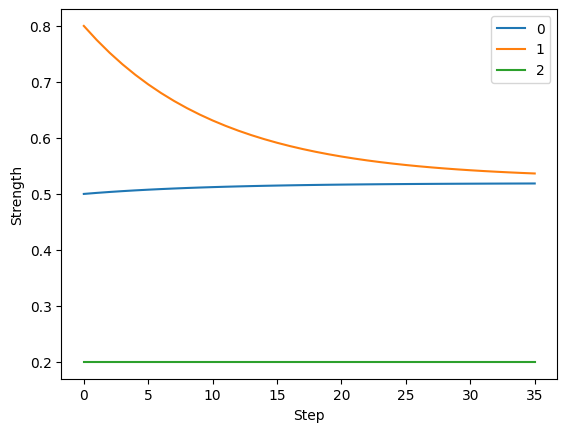

In [6]:
fig = plot(collector.output())

To make the above functions capatiable to the existing package, a number of adaptor functions should be defined as well to transfer the output data (node and edge tables) into what is needed as input, that are the argument strength vector and the parent vectors. 

To demonstrate how it works, we implement it with the stock example. Note that irrelevent columns are not included in the code below. Also in the edge tables, indices of arguments are used instead of the argument content.

In [7]:
import pandas as pd

df_nodes = pd.DataFrame({
    "argument": ["Buy", "Sell", "1", "2", "3", "4", "5"], 
    "coherence": [0.5, 0.5, 0.8, 0.7, 0.3, 0.9, 0.9]
})

df_attacks = pd.DataFrame({
    "source": [0, 1, 3, 4, 5, 6], 
    "target": [1, 0, 2, 3, 4, 2]
})

df_supports = pd.DataFrame({
    "source": [2, 3, 5, 6], 
    "target": [1, 0, 3, 0]
})

In [8]:
# Adaptor functions
def validate(data: pd.DataFrame, columns: list):
    if not set(columns).issubset(data.columns):
        raise ValueError(f"One or more in {columns} missing.")

def get_weights(df_arguments: pd.DataFrame) -> np.ndarray:
    return df_arguments["coherence"].to_numpy(dtype=float)
    
def get_parent_vectors(df_arguments: pd.DataFrame, df_attacks: pd.DataFrame = None, df_supports: pd.DataFrame = None) -> np.ndarray:
    num_argu = len(df_arguments)
    result = np.zeros((num_argu, num_argu))
    
    def add_attacks(r):
        result[r["target"], r["source"]] = -1
        
    def add_supports(r):
        result[r["target"], r["source"]] = 1
    if df_attacks is not None:    
        df_attacks.apply(lambda r: add_attacks(r), axis=1)
    if df_supports is not None:
        df_supports.apply(lambda r: add_supports(r), axis=1)
    
    return result

In [9]:
weights = get_weights(df_arguments=df_nodes)
vs = get_parent_vectors(df_arguments=df_nodes, df_attacks=df_attacks, df_supports=df_supports)
vs

array([[ 0., -1.,  0.,  1.,  0.,  0.,  1.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [10]:
# Result looks quite similar to the give notebook
# As mentioned before, there are some errors of implementations
# in the given uncertainpy package, my guess the difference 
# comes from there

v_strength = copy.deepcopy(weights)

step, v_strength, collector = rk4(v_strength=v_strength, weights=weights, step_size=step_size, max_iter=max_iter)

print(f"Convergence reached at step {step}, \nfinal strenght: {v_strength}")

Convergence reached at step 53, 
final strenght: [0.83785438 0.36062206 0.18636607 0.94242274 0.166416   0.9
 0.9       ]


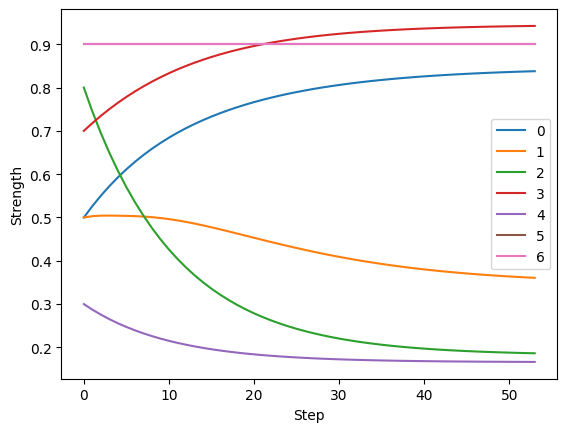

In [11]:
fig = plot(collector.output())